In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_armonk')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
import numpy as np

dt = config.dt

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qb = 0

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

In [5]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

inst_sched_map = defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qb)

In [6]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [7]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [8]:
pulse_info = [[208, 1616, 0.4235238255511584],
 [240, 1984, 0.35785919192009924],
 [288, 2336, 0.29869942089171625],
 [336, 2704, 0.2538870311410756],
 [384, 3056, 0.22165413706048734],
 [432, 3424, 0.19926012331224413],
 [480, 3776, 0.17796453073600368],
 [512, 4144, 0.16745387953645477],
 [560, 4496, 0.15179216078521446],
 [608, 4864, 0.1403380794470017]]

In [18]:
delay_times_dt

array([   4500.,   31500.,   58500.,   85500.,  112500.,  139500.,
        166500.,  193500.,  220500.,  247500.,  274500.,  301500.,
        328500.,  355500.,  382500.,  409500.,  436500.,  463500.,
        490500.,  517500.,  544500.,  571500.,  598500.,  625500.,
        652500.,  679500.,  706500.,  733500.,  760500.,  787500.,
        814500.,  841500.,  868500.,  895500.,  922500.,  949500.,
        976500., 1003500., 1030500., 1057500., 1084500., 1111500.,
       1138500., 1165500., 1192500., 1219500., 1246500., 1273500.,
       1300500., 1327500., 1354500., 1381500., 1408500., 1435500.,
       1462500., 1489500., 1516500., 1543500., 1570500., 1597500.,
       1624500., 1651500., 1678500., 1705500., 1732500., 1759500.,
       1786500., 1813500., 1840500., 1867500., 1894500., 1921500.,
       1948500., 1975500., 2002500.])

In [20]:
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)

delay_times_dt = times_us * us / config.dt

t1_schedules = []
for i in range(len(pulse_info)):
    for delay in delay_times_dt:
        sched = qiskit.pulse.Schedule(name=f'T1 delay + {delay * config.dt/us} us')
        
        sched += qiskit.pulse.Play(pulse_lib.gaussian(duration=pulse_info[i][1], 
                                                      amp=pulse_info[i][2], 
                                                      sigma=pulse_info[i][0], 
                                                      name=f"Rabi drive amplitude = {pulse_info[i][2]}"), drive_chan)
#         sched += qiskit.pulse.Play(SamplePulse(Xp(qb).samples, name=f'Xp{qb}'), drive_chan)

        sched += measure << (sched.duration + int(delay))
        t1_schedules.append(sched)

num_shots = 1024

t1_experiment = assemble(t1_schedules,
                        backend=backend, 
                        meas_level=1,
                        meas_return='avg',
                        shots=num_shots,
                        schedule_los=[{drive_chan: defaults.qubit_freq_est[qb]}] * len(t1_schedules))
job = backend.run(t1_experiment)

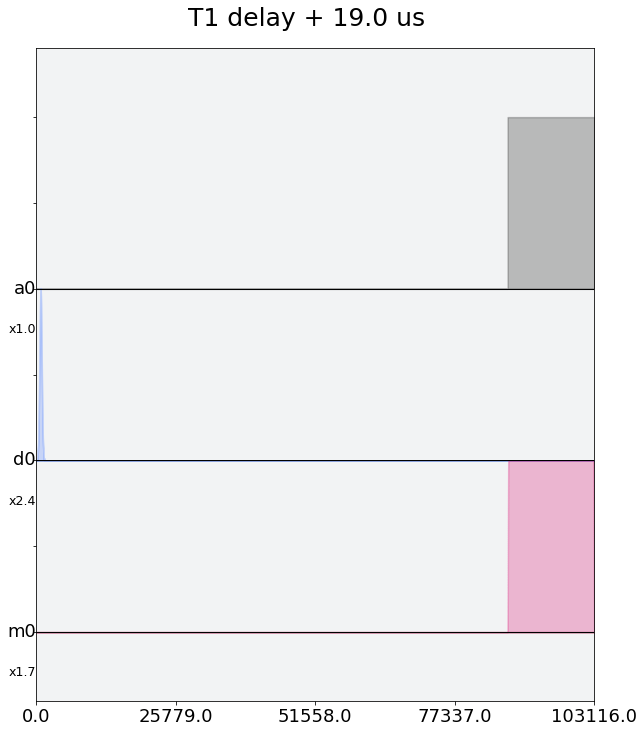

In [17]:
t1_schedules[3].draw()

In [19]:
t1_results = job.result(timeout=120)
t1_values = []
all_T1s = []
all_fits = []

for i in range(len(pulse_info)):
    single_amp_data = []
    for j in range(len(delay_times_dt)):
        single_amp_data.append(t1_results.get_memory((i * len(times_us) + j))[qb] * scale_factor)
    
    single_amp_data = np.real(single_amp_data)
    t1_values.append(single_amp_data)
    
    fun = lambda x, A, C, T1: (A * np.exp(-x / T1) + C)
    p, y_fit = fit_function(times_us, single_amp_data, fun, 
                     [-3, -3, 100])
    _, _, T1 = p
    all_T1s.append(T1)
    all_fits.append(y_fit)

IBMQJobInvalidStateError: 'Unable to retrieve result for job 5ef23f280935ad0012f62938. Job was cancelled.'

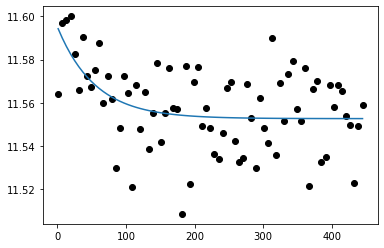

In [55]:
a = 7
plt.scatter(times_us, t1_values[a], color='black') # plot real part of Rabi values
plt.plot(times_us, all_fits[a])

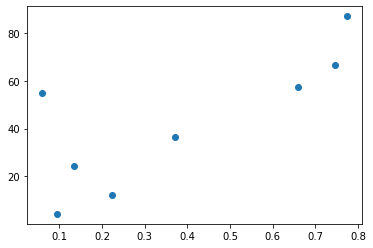

In [56]:
plt.scatter(np.array(pulse_info)[:, 2], all_T1s)